# 11_05.토픽 모델링(gensim IDM: Intertopic Distance Map)
- https://radimrehurek.com/gensim/models/ldamodel.html
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://lovit.github.io/nlp/2019/06/10/visualize_topic_models_with_pyldavis/
- https://lovit.github.io/nlp/2018/09/27/pyldavis_lda/
- https://lovit.github.io/nlp/2018/09/27/pyldavis_kmeans/

## 1.기본 package 설정

### 1.1 그래프 한글 인식 세팅

In [ ]:
# 단어 빈도 및 워드 클라우드에 한글 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#  *** 런타임 다시 시작

### 1.2 KoNLPY 세팅

In [ ]:
! pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 34.8 MB/s eta 0:00:00


### 1.3 package 설정

In [ ]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import pandas as pd # pandas 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns # 시각화

## 2.데이터 전처리
import re                             # 정규식 모듈 임포트

## 3.형태소 처리
from konlpy.tag import Okt

## 4.토픽만들기
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from pprint import pprint

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.데이터 가져오기

### 2.1 구글 드라이브와 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tm_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tm.csv', encoding="cp949")
tm_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,no,구분,전공,본문
0,1,post,전공,코로나19라는 펜데믹 상황에서 \n사람이 모이면 안되는 상황인지라 실험을 진행하는데...
1,2,pre,교양,"3시간이라는 시간이 조금 길 수도 있겠다는 생각이 들지만, 필요한 정보를 많이 얻을..."
2,3,pre,교양,가장 특이하지만 또 가장 이상적인 모습의 교수님이었습니다 나무가 아닌 숲을 보는 수...
3,4,pre,교양,"각자의 생각이 다르고, 대학에 온 이유도 다를텐데, 동영상 ucc제작을 하는 이유를..."
4,5,pre,교양,강사님에 따라 강의 시간이 좋기도 하고 지루하기도 했다.


In [ ]:
tm_df.info()

In [ ]:
tm_df['본문'].iloc[0]

### 2.2 문서 전처리 및 동음이의어 정리
- 기본적인 문서 전처리 작업을 하고
- 단어빈도분석을 한 후에, 문제 있는 단어를 찾은 후에 정리

In [ ]:
tm_list = []

for i in range(len(tm_df)):
    text = tm_df['본문'].iloc[i]
    text = re.sub('[\x00-\x1F\x7F]', "", text)                # 제어문자[\n, \t] 제거 [[:cntrl:]]
    text = re.sub("[\W]", " ", text)                          # 구두점 등 제거 - 문자와 숫자만 저장
    #text = re.sub("[^\D]", " ", text)                         # 숫자제거
    text = re.sub('(Zoom 수업|Zoom수업|줌 수업)', '줌수업', text)
    text = re.sub('강의', '수업', text)
    tm_list.append(text)

# 2개 단어를 한단어로 통합
# re.sub('(강서 대학교|강서대학|강서 대학)', '강서대학교', text)

# 같은 단어를 한 단어로 변경
# re.sub("공부\\w*", "공부", word)
# re.sub("\\w*\\습니\\w*", "삭제", word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence '\W'
<>:6: DeprecationWarning: invalid escape sequence '\W'
<ipython-input-6-630a213000ec>:6: DeprecationWarning: invalid escape sequence '\W'
  text = re.sub("[\W]", " ", text)                          # 구두점 등 제거 - 문자와 숫자만 저장


In [ ]:
tm_list[0]

## 3.형태소로 분리 및 불용어제거
- https://konlpy.org/ko/latest/api/konlpy.tag/
- 명사와 동사 추출
- 한단어 삭제
- 동사만 추출은 부록 참고
- 불용어 제거: 단어빈도분석을 한 후에, 문제 있는 단어를 찾은 후에 불용어 제거

In [ ]:
# 명사와 동사추출
okt = Okt()
words_list = []
stop_words = ["하다", "있다", "되어다", "수업", "교수", "학생", "이다"]

# list형태로 추출해야 되기 때문에 수정
for i in range(len(tm_list)):
    text = tm_list[i]
    morp = okt.pos(text, stem=True)                  # stem = 동사 원형 추출
    words = [
        '{}'.format(word) for word, tag in morp      # word 만 추출
        if ((tag in ['Noun'] or tag in ['Verb'])     # 명사와 동사 추출
            and (len(word) > 1)                      # 한 글자 단어 삭제
            and (word not in stop_words))           # 불용어 삭제
    ]
    words_list.append(words)

# 원문장
# words = ['{}'.format(word) for word, tag in morp if ((tag in ['Noun'] or tag in ['Verb']) and (len(word) > 1) and (word not in stop_words))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
words_list

1998

## 4.단어사전(Dictionary) 만들기
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# 단어사전(Dictionary) 만들기
id2word = corpora.Dictionary(words_list)
print(id2word)

Dictionary<2871 unique tokens: ['공지', '과제', '누락', '늦다', '다만']...>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
id2word[0]

'공지'

In [ ]:
# corpus(term document frequency)
id2word.filter_extremes(no_below = 5) # 5회 이하로 등장한 단어는 삭제
corpus = [id2word.doc2bow(text) for text in words_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 3),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1)]

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('공지', 2),
  ('과제', 1),
  ('늦다', 1),
  ('다만', 1),
  ('대학', 1),
  ('대해', 1),
  ('되다', 1),
  ('들다', 2),
  ('또한', 1),
  ('바로', 1),
  ('방식', 1),
  ('사람', 1),
  ('상황', 2),
  ('생각', 2),
  ('생기', 1),
  ('생기다', 1),
  ('서로', 1),
  ('않다', 1),
  ('올려주다', 1),
  ('인지', 1),
  ('제출', 1),
  ('조금', 3),
  ('주시', 1),
  ('진행', 2),
  ('찾다', 1),
  ('최대한', 1),
  ('코로나', 1),
  ('파일', 1),
  ('피드백', 1),
  ('피해', 1),
  ('해결', 1),
  ('해주다', 1)]]

## 5.Topic 만들기

### 5.1 최적 토픽수 찾기

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

min, max, step = 2, 10, 1
coherence_scores = []
model_list = []

for i in range(min, max, step):
    lda_model = LdaModel(corpus = corpus,
                         num_topics = i,
                         random_state = 1,
                         id2word = id2word)
    model_list.append(lda_model)
    coherence = CoherenceModel(model = lda_model,
                               texts = words_list,
                               dictionary = id2word,
                               coherence = 'c_v')
    coherence_scores.append(coherence.get_coherence())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 높을 수록 좋은 모델
x = [i for i in range(min, max, step)]

for m, cv in zip(x, coherence_scores):
    print("Topic =", m, ", coherence = ", round(cv, 4))

Topic = 2 , coherence =  0.491
Topic = 3 , coherence =  0.504
Topic = 4 , coherence =  0.4921
Topic = 5 , coherence =  0.4827
Topic = 6 , coherence =  0.4794
Topic = 7 , coherence =  0.4738
Topic = 8 , coherence =  0.4967
Topic = 9 , coherence =  0.4809


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-14-a8c2c54db953>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


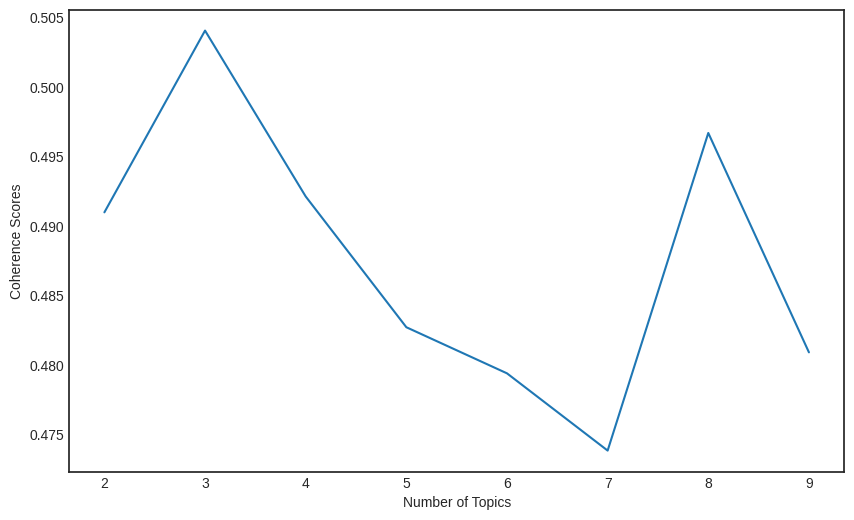

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

x = [i for i in range(min, max, step)]

plt.figure(figsize=(10,6))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

### 5.2 최적 토픽 분석

In [ ]:
# model_list[1] = 3개 선택
best_model = model_list[1]
model_topics = best_model.show_topics
pprint(best_model.print_topics(num_words = 15))

[(0,
  '0.026*"되다" + 0.026*"해주다" + 0.022*"감사하다" + 0.020*"과제" + 0.020*"시간" + '
  '0.017*"않다" + 0.015*"과목" + 0.015*"시험" + 0.014*"내용" + 0.012*"배우다" + '
  '0.012*"생각" + 0.012*"주다" + 0.010*"실습" + 0.010*"보다" + 0.010*"정말"'),
 (1,
  '0.042*"해주다" + 0.022*"시험" + 0.021*"감사하다" + 0.017*"과제" + 0.017*"내용" + '
  '0.016*"않다" + 0.015*"되다" + 0.013*"시간" + 0.013*"들다" + 0.013*"설명" + '
  '0.013*"배우다" + 0.012*"이해" + 0.012*"진행" + 0.012*"보다" + 0.011*"생각"'),
 (2,
  '0.024*"감사하다" + 0.022*"학기" + 0.020*"들다" + 0.020*"않다" + 0.018*"자다" + '
  '0.016*"되다" + 0.014*"시간" + 0.014*"부분" + 0.013*"드리다" + 0.013*"과제" + '
  '0.012*"대해" + 0.011*"감사" + 0.011*"듣다" + 0.011*"생각" + 0.011*"동안"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### ** LDAvis 모델은 6번으로 바로 이동

## 6.토픽분석

### 6.1 토픽별 핵심단어 추출

In [ ]:
topics_df = pd.DataFrame()

for i in range(3):
    wp = best_model.show_topic(i)
    topic_keywords = ", ".join([word for word, prop in wp])
    topics_df = topics_df.append(pd.Series([int(i+1),
                                           topic_keywords]),
                                ignore_index = True)
topics_df.columns = ['토픽', '핵심단어']
topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

### 6.2 문서별 토픽 추출

In [ ]:
docs_topic_df = pd.DataFrame()

for i, row in enumerate(best_model[corpus]):
    row = sorted(row, key = lambda x: (x[1]), reverse = True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = best_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            docs_topic_df = docs_topic_df.append(pd.Series([int(topic_num),
                                                            round(prop_topic,4),
                                                            topic_keywords]),
                                                   ignore_index = True)

docs_topic_df = docs_topic_df.reset_index()
docs_topic_df.columns = ['문서번호','핵심토픽', '기여도(토픽)', '핵심단어']
docs_topic_df

### 6.3 각 주제에 대해 가장 대표적인 문서 찾기

In [ ]:
topics_doc_df = pd.DataFrame()

doc_topics_grdf = docs_topic_df.groupby('핵심토픽')

for i, grp in doc_topics_grdf:
    topics_doc_df = pd.concat([topics_doc_df,
                                grp.sort_values(['기여도(토픽)'], ascending=[0]).head(1)],
                                axis=0)

topics_doc_df

In [ ]:
topics_doc_df.reset_index(drop=True, inplace=True)
topics_doc_df.columns = ['문서번호','토픽', "기여도", "핵심단어"]
topics_doc_df.loc[:, ['토픽', '문서번호', "기여도", "핵심단어"]]

### 6.4 토픽별 문서분포

In [ ]:
topic_counts = docs_topic_df['핵심토픽'].value_counts()
# topic_counts.sort_index(inplace=True)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# topic_contribution.sort_index(inplace=True)
topic_num_keywords = topics_df[['토픽', '핵심단어']]

dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
dominant_topics.reset_index(drop=True, inplace=True)
dominant_topics.columns = ['핵심토픽', '핵심단어', '문서수', '기여도(문서)']

dominant_topics

## 7.LDAvis 그래프
- pd 버전을 이전 버전을 사용해야 되므로, 다시 런타임 실행
- 5번 토픽 모델에서 6번 실행하지 않고 바로 6번으로 이동

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.012376 -0.032651       1        1  38.097648
0     -0.028353  0.025100       2        1  31.210225
2      0.040729  0.007551       3        1  30.692126, topic_info=    Term        Freq       Total Category  logprob  loglift
31   해주다  486.000000  486.000000  Default  30.0000  30.0000
98    과목  122.000000  122.000000  Default  29.0000  29.0000
95    학기  246.000000  246.000000  Default  28.0000  28.0000
82    시험  265.000000  265.000000  Default  27.0000  27.0000
582   실습   96.000000   96.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
1     과제   70.774421  300.612450   Topic3  -4.3617  -0.2652
258   주다   45.609228  143.452759   Topic3  -4.8011   0.0353
57    내용   50.008817  246.383669   Topic3  -4.7090  -0.4135
21    조금   38.093257  124.436936   Topic3  -4.9812  -0.0026
31   해주다   51.818270  486.640252   Topic3  -4.6735  -1.0586

[240 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
121       1  0.573717    가다
121       2  0.278166    가다
121       3  0.139083    가다
187       1  0.584190  가르치다
187       2  0.230136  가르치다
...     ...       ...   ...
287       2  0.242552    활동
287       3  0.658356    활동
128       1  0.714056    흐름
128       2  0.238019    흐름
128       3  0.119009    흐름

[477 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])